In [1]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
import uproot
import pandas as pd
from scipy.optimize import fsolve, curve_fit
from scipy.stats import norm

from root_to_np import get_tree, get_df, rename_tree_branches

Welcome to JupyROOT 6.26/04
END OF SCRIPT


In [2]:
pad =3
index = pad-1

run = [627,632]
pad_name = [37,38,27,28]
which_mcp = np.array([[1,2,4],[1,2,4],[5,6,7],[5,6,7]])

In [3]:
data = []
for irun in run:
    tree = get_tree(irun)
    var_indexes = np.array([which_mcp[index][0],which_mcp[index][1],which_mcp[index][2],
                            index*10+8,index*10+9,index*10+12,index*10+14,index*10+11,
                       index*10+13,67,65,66])
    data_single = get_df(tree,*var_indexes)
    if index>1:
        old_names = ['mcp2_gpeak','mcp2_qall','mcp2_t']
        new_names = ['mcp_gpeak','mcp_qall','mcp_t']
        names = [old_names,new_names]
        data_single = rename_tree_branches(data_single,*names)
    
    print(len(data_single))
    data.append(data_single)

data = pd.concat(data,ignore_index=True)
print(data.head())
print(len(data))

['Pico;1']
['srs', 'mcp_gpeak', 'mcp_qall', 'mcp_tnaive', 'mcp_t', 'mcp2_gpeak', 'mcp2_qall', 'mcp2_t', 'mm1_gpeak', 'mm1_qall', 'mm1_tnaive', 'mm1_t', 'mm1_qe', 'mm1_pl3', 'mm1_qfit', 'mm1_xh', 'mm1_qh', 'mm1_gmin', 'mm2_gpeak', 'mm2_qall', 'mm2_tnaive', 'mm2_t', 'mm2_qe', 'mm2_pl3', 'mm2_qfit', 'mm2_xh', 'mm2_qh', 'mm2_gmin', 'mm3_gpeak', 'mm3_qall', 'mm3_tnaive', 'mm3_t', 'mm3_qe', 'mm3_pl3', 'mm3_qfit', 'mm3_xh', 'mm3_qh', 'mm3_gmin', 'mm4_gpeak', 'mm4_qall', 'mm4_tnaive', 'mm4_t', 'mm4_qe', 'mm4_pl3', 'mm4_qfit', 'mm4_xh', 'mm4_qh', 'mm4_gmin', 'nmm1_x', 'mm1_x', 'nmm1_y', 'mm1_y', 'nmm2_x', 'mm2_x', 'nmm2_y', 'mm2_y', 'nmm3_x', 'mm3_x', 'nmm3_y', 'mm3_y', 'nmm4_x', 'mm4_x', 'nmm4_y', 'mm4_y', 'ntracks', 'xy', 'chi2', 'track_flag', 'ndetsintrack', 'distnextcluster']
<Report start=0 stop=10913 source='/home/evridiki/Downloads/test_run627.root:/Pico;1'>
<Report start=10913 stop=21826 source='/home/evridiki/Downloads/test_run627.root:/Pico;1'>
<Report start=21826 stop=32739 source='/

## Calculations -Setup

In [4]:
mcp_overflow = (data.mcp_gpeak>0.3)*(data.mcp_gpeak<=0.72)
chi2_cut = (data.chi2<=40)*(data.track_flag>0)

mcp_basic_cut = mcp_overflow*chi2_cut

In [5]:
c = ROOT.TCanvas()

In [6]:
mm_gpeak = f'mm{pad}_gpeak'
mm_qall = f'mm{pad}_qall'
mm_qe = f'mm{pad}_qe'
mm_qfit = f'mm{pad}_qfit'
mm_t = f'mm{pad}_t'
mm_overflow = (data[mm_gpeak]>0.)*(data[mm_gpeak]<0.36)*(data[mm_qall]>0)
qe_line = (data[mm_qe]>30.*data[mm_gpeak])

mm_basic_cut = np.logical_and(mm_overflow*mcp_basic_cut,qe_line)

In [7]:
centers_from_fit = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/pad_centers.txt',
                delimiter=" ", unpack=False)
xc = centers_from_fit[0][index]
yc = centers_from_fit[1][index]

def transfo(x,y,x0,y0, theta): #from sym to beam frame and vice versa
    dx=x-x0
    dy=y-y0
    return (dx*np.cos(theta)+dy*np.sin(theta), -dx*np.sin(theta)+dy*np.cos(theta))

cross_beam = [22.39996479308732, 25.69888050613195]
theta_beam = -1.0203e-02
theta_local=-theta_beam

xc,yc = transfo(xc,yc,cross_beam[0],cross_beam[1],theta_local) #in local

In [8]:
cable_delay = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/cable_delay.txt')
#slew_par = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/global_slew_fit.txt')
slew_par = np.loadtxt(f'/home/evridiki/Desktop/JULY_RUNS/run_{run[0]}_{run[1]}_info/slew_fit.txt')

def double_expo(x,*p):
    return np.exp(p[0]*x+p[1])+np.exp(p[2]*x+p[3])+p[4]

In [9]:
p2 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(0))
p3 = np.loadtxt('/home/evridiki/Desktop/JULY_RUNS/run_627_632_info/scale_par.txt',
                delimiter=" ", usecols=(1))

## Before timing correction

num of events 48351  and mean now  -8959.663242382061
num of events after cut 48341  and mean now  -8891.148260092106


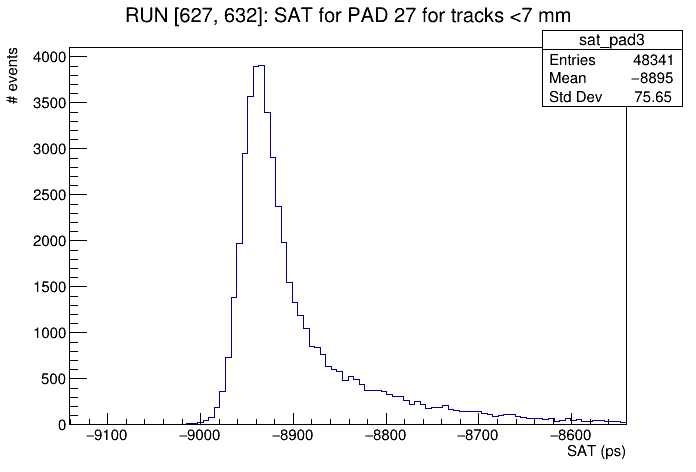

In [10]:
x = data.iloc[:,-4].values
y = data.iloc[:,-3].values
x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks

square_cut = np.logical_and(np.abs(x-xc)<7., np.abs(y-yc)<7.)
mm_time_cut = mm_basic_cut*(data[mm_gpeak]>0.02)*square_cut

sat = (data[mm_t][mm_time_cut] - data.mcp_t[mm_time_cut])*1000 #ps
print('num of events',len(sat),' and mean now ',sat.mean())

#in each pad remain about ~200 tracks with times waaaay out of range, so we apply a filter
sat = sat[np.abs(sat-sat.mean())<=1000]
print('num of events after cut',len(sat),' and mean now ',sat.mean())

sat_pad = ROOT.TH1F(f'sat_pad{pad}', f'RUN {run}: SAT for PAD {pad_name[index]} for tracks <7 mm', 
                    100,sat.mean()-250,sat.mean()+350)

sat_pad.GetXaxis().SetTitle("SAT (ps)")
sat_pad.GetYaxis().SetTitle('# events')

sat_pad.FillN(len(sat),sat.values,np.ones(len(sat)))

sat_pad.Draw()
c.Draw()


 FCN=54.5235 FROM MIGRAD    STATUS=CONVERGED      78 CALLS          79 TOTAL
                     EDM=2.5069e-11    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     5.02773e+02   9.72066e+00   2.75978e-02  -3.61395e-08
   2  Mean        -8.94318e+03   2.39789e-01   4.26444e-03  -2.28147e-05
   3  Sigma        1.58233e+01   1.91301e-01   1.08934e-05   1.25029e-03


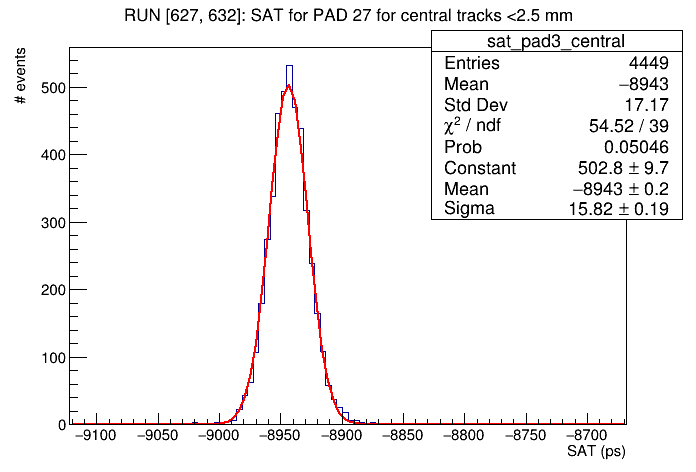

In [11]:
ROOT.gStyle.SetOptFit(1111)
x = data.iloc[:,-4].values
y = data.iloc[:,-3].values
x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks

square_cut = np.logical_and(np.abs(x-xc)<2., np.abs(y-yc)<2.)
mm_time_cut = mm_basic_cut*(data[mm_gpeak]>0.02)*square_cut

sat = (data[mm_t][mm_time_cut] - data.mcp_t[mm_time_cut])*1000 #ps
sat_pad_central = ROOT.TH1F(f'sat_pad{pad}_central', 
                            f'RUN {run}: SAT for PAD {pad_name[index]} for central tracks <2.5 mm',
                            100,sat_pad.GetMean()-3*sat_pad.GetStdDev(),sat_pad.GetMean()+3*sat_pad.GetStdDev())

sat_pad_central.GetXaxis().SetTitle("SAT (ps)")
sat_pad_central.GetYaxis().SetTitle('# events')

sat_pad_central.FillN(len(sat),sat.values,np.ones(len(sat)))

c.Clear()
sat_pad_central.Fit("gaus")
sat_pad_central.Draw()
c.Draw()

In [12]:
#theta: r,sat,sat_error, rms, rms_error
projection_seed = []
for theta in [0,np.pi/4,np.pi/2, 3*np.pi/4]:
    arr = np.empty((0,5))
    for r in range(-7,8,1):
        x0 = xc +r*np.cos(theta)
        y0 = yc +r*np.sin(theta)
        
        x = data.iloc[:,-4].values
        y = data.iloc[:,-3].values
        x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
        
        seed =np.logical_and( mm_basic_cut,np.sqrt((x-x0)**2 + (y-y0)**2)<0.5)
        
        
        sat = (data[mm_t][seed] - data.mcp_t[seed])*1000 
        sat = sat[np.abs(sat-sat_pad.GetMean())<=1000]
        
        sat_pad_seed = ROOT.TH1F("", "",
                                 50,sat.mean()-5*sat.std(),sat.mean()+5*sat.std())
        
        sat_pad_seed.FillN(len(sat), sat.values, np.ones(len(sat)) )
        result = sat_pad_seed.Fit("gaus","SQ")
        arr = np.append(arr,
                             np.array([[r, result.Parameter(1),result.ParError(1), 
                                        result.Parameter(2),result.ParError(2)]]),
                            axis = 0)
        
    projection_seed.append(arr)
        


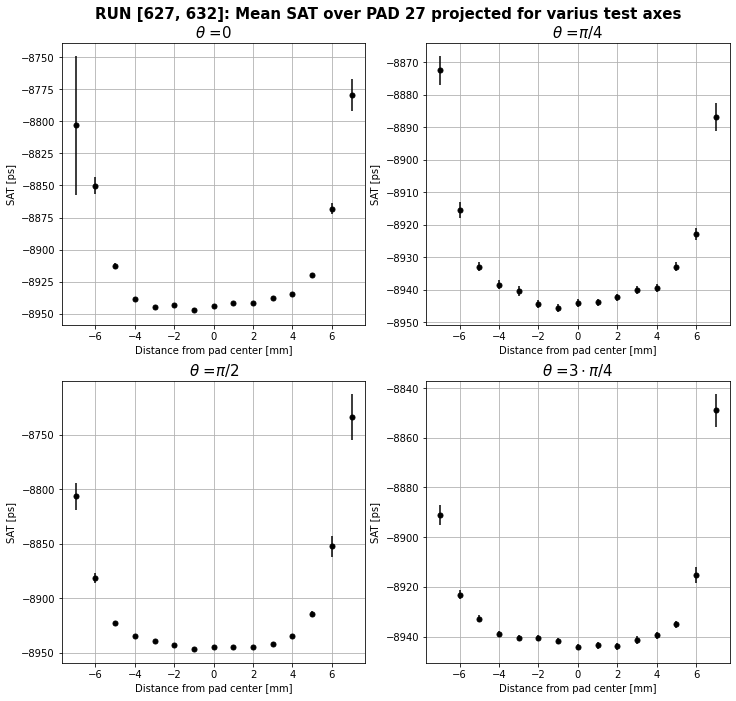

In [13]:
fig, axes = plt.subplots(figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f'RUN {run}: Mean SAT over PAD {pad_name[index]} projected for varius test axes',
             fontsize=15, fontweight='bold')

i=0
for theta in ['0','$\pi/4$','$\pi/2$', '$3\cdot\pi/4$']:
    plt.subplot(2, 2, i + 1)
    
    x = projection_seed[i][:,0]
    y = projection_seed[i][:,1]
    y_er = projection_seed[i][:,2]
    
    plt.errorbar(x,y, yerr =y_er ,fmt='o', markersize=5.,color = 'black' )
    plt.title(r'$\theta$ =' f'{theta}',fontsize=15)
    plt.xlabel('Distance from pad center [mm]')
    plt.ylabel('SAT [ps]')
    plt.grid()

    i = i+1


plt.show()

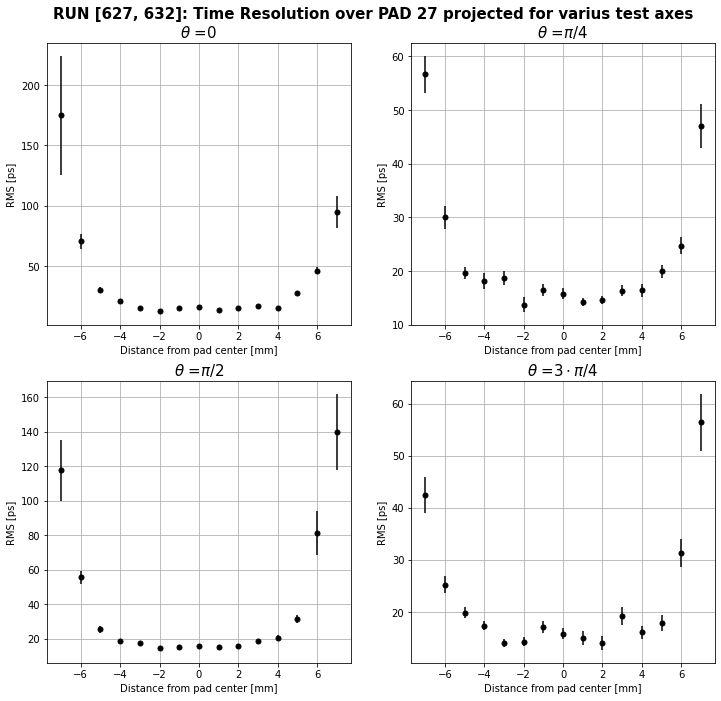

In [14]:
fig, axes = plt.subplots(figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f'RUN {run}: Time Resolution over PAD {pad_name[index]} projected for varius test axes',
             fontsize=15, fontweight='bold')

i=0
for theta in ['0','$\pi/4$','$\pi/2$', '$3\cdot\pi/4$']:
    plt.subplot(2, 2, i + 1)
    
    x = projection_seed[i][:,0]
    y = projection_seed[i][:,3]
    y_er = projection_seed[i][:,4]
    
    plt.errorbar(x,y, yerr =y_er ,fmt='o', markersize=5.,color ='black' )
    plt.title(r'$\theta$ =' f'{theta}',fontsize=15)
    plt.xlabel('Distance from pad center [mm]')
    plt.ylabel('RMS [ps]')
    plt.grid()
    
    i = i+1


plt.show()

In [15]:
def t_range_cut(t1,t2, i):
    t_low = [-8500,-8500,-9800,-8800]
    t_up = [-6500,-6500,-7500, -6700]

    t = (t1-t2)*1000 #ps

    return np.logical_and(t>=t_low[i],t<=t_up[i])

In [16]:
def slew_resol(sat,x,len_xbin,t_out_of_range=200):   
    d = {'sat':sat,'x':x}
    t_fun_x = pd.DataFrame(data=d)

    # sort
    t_fun_x.sort_values(by=['x'], inplace=True)
    print('number of valid events ',len(t_fun_x))
    #binning
    num_points = round(len(t_fun_x)/len_xbin)

    print('points of graph ',num_points)
    arr = np.empty((0,7))
    for j in range(num_points):
        start =j*len_xbin
        end = (j+1)*len_xbin
        if(end>len(t_fun_x)):
            end = len(t_fun_x)
        x = t_fun_x.iloc[start:end,1].values
        t = t_fun_x.iloc[start:end,0].values
        
        mean = np.average(t,weights = np.abs(1/(t-t.mean())))
        t = t[np.abs(t-mean)<=t_out_of_range] # to cut times waaay out of range
        if(len(t)==0):
            print('zero left')
            continue
        
        xbin_hist = ROOT.TH1F(""," ", 100,t.mean()-10*t.std(),t.mean()+10*t.std());
        xbin_hist.FillN(len(t),t,np.ones(len(t)))
        result = xbin_hist.Fit('gaus','QS')
        arr = np.append(arr,
                        np.array([[x.mean() , np.abs(x[0]-x.mean()), np.abs(x[-1]-x.mean()),
                                  result.Parameter(1), result.ParError(1), result.Parameter(2),result.ParError(2)]]),
                        axis = 0)
    
    return arr

In [17]:
from_distance = np.array([0.,2.,5.])
to_distance = np.array([from_distance[1],from_distance[2],7.])

time_across_pad =[]

for i in range(len(from_distance)):
    
    x = data.iloc[:,-4].values
    y = data.iloc[:,-3].values
    x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
    
    inner_square = np.logical_and(np.abs(x-xc)<=from_distance[i],
                            np.abs(y-yc)<=from_distance[i])
    outer_square = np.logical_and(np.abs(x-xc)<=to_distance[i],
                            np.abs(y-yc)<=to_distance[i])

    slice_cut = np.logical_and(np.logical_not(inner_square),outer_square)
    mm_time_cut = data[mm_qall]<=100*np.logical_and(mm_basic_cut,slice_cut)
    mm_time_cut = mm_time_cut*t_range_cut(data[mm_t],data['mcp_t'],index)
    mm_time_cut = mm_time_cut*(p2[index]*data[mm_qall]+p3[index]>0.5)
    
    #a subset of our df
    q_scale = p2[index]*data[mm_time_cut][mm_qall]+p3[index]
    sat = (data[mm_time_cut][mm_t]-data[mm_time_cut]['mcp_t'])*1000 - cable_delay[index] +10.
    time_across_pad.append(slew_resol(sat,q_scale,300+i*200,500))

number of valid events  4450
points of graph  15
number of valid events  24385
points of graph  49
number of valid events  21152
points of graph  30


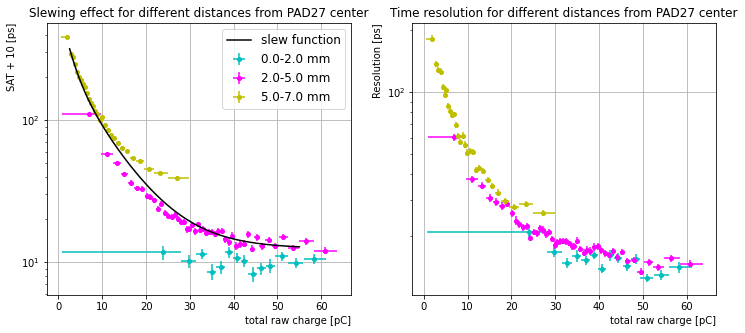

In [18]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
color = np.array(['c','magenta','y'])

for i in range(len(from_distance)):

    q = time_across_pad[i][:-1,0]
    q_error=[time_across_pad[i][:-1,1],time_across_pad[i][:-1,2]]
    sat =  time_across_pad[i][:-1,3] 
    sat_error = time_across_pad[i][:-1,4]
    axes[0].errorbar(q,sat, yerr =sat_error ,xerr=q_error,fmt='o',
             label =f'{from_distance[i]:.1f}-{to_distance[i]:.1f} mm',color = color[i], markersize=4. )
    
    res = time_across_pad[i][:-1,5]
    res_error = time_across_pad[i][:-1,6]
    axes[1].errorbar(q,res, yerr =res_error ,xerr=q_error,fmt='o',
             label =f'{from_distance[i]:.1f}-{to_distance[i]:.1f} mm',color = color[i], markersize=4. )


x = np.linspace(2.55,55,2000)
axes[0].plot(x,double_expo(x,*slew_par),color='black', label = 'slew function',zorder=3)

axes[0].set_xlabel('total raw charge [pC]',loc='right')
axes[0].set_ylabel('SAT + 10 [ps]',loc='top')
axes[0].grid()
axes[0].legend(prop={'size': 12})
#axes[0].set_ylim(0,30)
axes[0].set_yscale('log')
axes[0].set_title(f'Slewing effect for different distances from PAD{pad_name[index]} center')

axes[1].set_xlabel('total raw charge [pC]',loc='right')
axes[1].set_ylabel('Resolution [ps]',loc='top')
axes[1].grid()
axes[1].set_yscale('log')
axes[1].set_title(f'Time resolution for different distances from PAD{pad_name[index]} center')

plt.show()

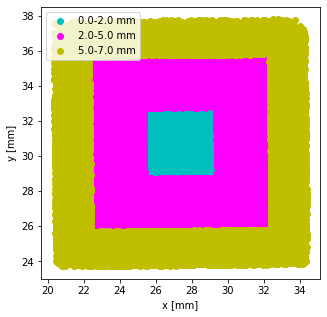

In [19]:
fig, ax = plt.subplots(figsize=(5,5))
for i in range(3):
    x = data.iloc[:,-4].values
    y = data.iloc[:,-3].values
    x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
    
    inner_square = np.logical_and(np.abs(x-xc)<=from_distance[i],
                            np.abs(y-yc)<=from_distance[i])
    outer_square = np.logical_and(np.abs(x-xc)<=to_distance[i],
                            np.abs(y-yc)<=to_distance[i])

    slice_cut = np.logical_and(np.logical_not(inner_square),outer_square)
    mm_time_cut = np.logical_and(mm_basic_cut*data[mm_gpeak]>0.01,slice_cut)
    
    x = data[mm_time_cut].iloc[:,-4].values
    y = data[mm_time_cut].iloc[:,-3].values
    ax.scatter(x,y,color = color[i],
             label =f'{from_distance[i]:.1f}-{to_distance[i]:.1f} mm')

ax.legend()
ax.set_xlabel('x [mm]')
ax.set_ylabel('y [mm]')
plt.show()

number of valid events  4122
points of graph  14
number of valid events  15292
points of graph  31


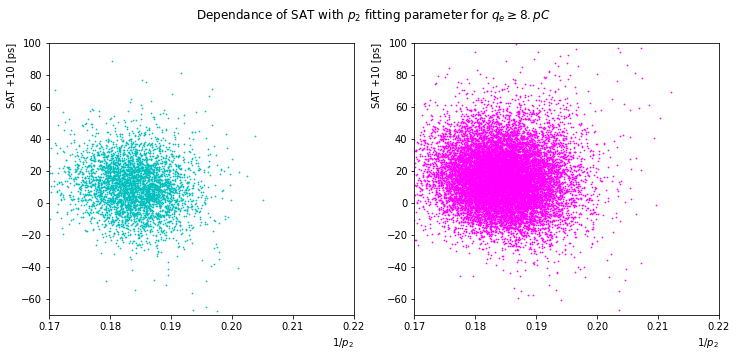

In [20]:
fig, axes = plt.subplots(1,2,figsize=(12,5))
t_fun_pl3 = []
for i in [0,1]:
    
    x = data.iloc[:,-4].values
    y = data.iloc[:,-3].values
    x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
    
    inner_square = np.logical_and(np.abs(x-xc)<=from_distance[i],
                            np.abs(y-yc)<=from_distance[i])
    outer_square = np.logical_and(np.abs(x-xc)<=to_distance[i],
                            np.abs(y-yc)<=to_distance[i])

    slice_cut = np.logical_and(np.logical_not(inner_square),outer_square)
    mm_time_cut = data[mm_qall]<=120*np.logical_and(mm_basic_cut*data[mm_qall]>30.,slice_cut)
    mm_time_cut = mm_time_cut*t_range_cut(data[mm_t],data['mcp_t'],index)
    mm_time_cut = mm_time_cut*(p2[index]*data[mm_qall]+p3[index]>0.5)
    
    #a subset of our df
    inv_pl3 = 1./data[mm_time_cut][f'mm{pad}_pl3']
    sat = (data[mm_time_cut][mm_t]-data[mm_time_cut]['mcp_t'])*1000 - cable_delay[index] +10.
    
    t_fun_pl3.append(slew_resol(sat,inv_pl3,300+i*200,150))
    
    axes[i].scatter(inv_pl3,sat,color=color[i], s=0.5)
    axes[i].set_ylim(-70,100)
    axes[i].set_xlim(0.17,0.22)
    axes[i].set_xlabel(r'$1/p_2$',loc='right')
    axes[i].set_ylabel('SAT +10 [ps]',loc = 'top')
    
fig.suptitle(r'Dependance of SAT with $p_2$ fitting parameter for $q_e\geq 8. pC$')

plt.show()

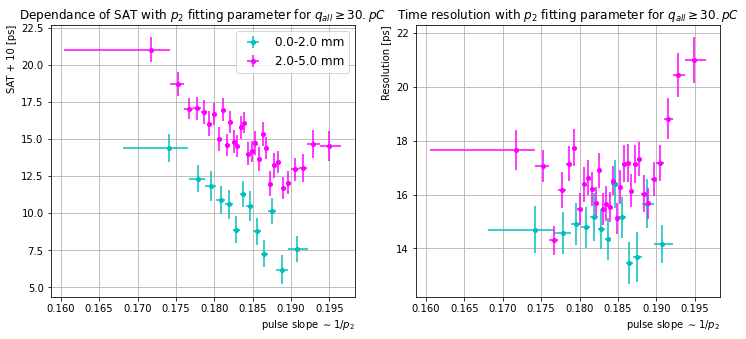

In [21]:
fig, axes = plt.subplots(1,2,figsize=(12,5))

for i in [0,1]:

    pl3 = t_fun_pl3[i][:-1,0]
    pl3_error=[t_fun_pl3[i][:-1,1],t_fun_pl3[i][:-1,2]]
    sat =  t_fun_pl3[i][:-1,3] 
    sat_error = t_fun_pl3[i][:-1,4]
    axes[0].errorbar(pl3,sat, yerr =sat_error ,xerr=pl3_error,fmt='o',
             label =f'{from_distance[i]:.1f}-{to_distance[i]:.1f} mm',color = color[i], markersize=4. )
    
    res = t_fun_pl3[i][:-1,5]
    res_error = t_fun_pl3[i][:-1,6]
    axes[1].errorbar(pl3,res, yerr =res_error ,xerr=pl3_error,fmt='o',
             label =f'{from_distance[i]:.1f}-{to_distance[i]:.1f} mm',color = color[i], markersize=4. )


axes[0].set_xlabel(r'pulse slope $\sim 1/p_2$',loc='right')
axes[0].set_ylabel('SAT + 10 [ps]',loc='top')
axes[0].grid()
axes[0].legend(prop={'size': 12})
axes[0].set_title(r'Dependance of SAT with $p_2$ fitting parameter for $q_{all}\geq 30. pC$')

axes[1].set_xlabel(r'pulse slope $\sim 1/p_2$',loc='right')
axes[1].set_ylabel('Resolution [ps]',loc='top')
axes[1].grid()
axes[1].set_title(r'Time resolution with $p_2$ fitting parameter for $q_{all}\geq 30. pC$')

plt.show()

## We apply global timing correction here

In [22]:
#x,y,sat,sat_error, rms, rms_error
x0 =xc
y0 = yc
step = 2
pad_seed = np.empty((0,6))
for xstep in range(-5,5,step):
    for ystep in range(-5,5,step):
        
        x = data.iloc[:,-4].values
        y = data.iloc[:,-3].values
        x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
        
        seed = mm_basic_cut*np.logical_and(np.abs(x-(x0+xstep+1))<step/2, 
                                           np.abs(y-(y0+ystep+1))<step/2)
        
        cable =cable_delay[index]-10
        
        q_scale = p2[index]*data[mm_qall][seed]+p3[index]
        cor = double_expo(q_scale, *slew_par)
        sat = ((data[mm_t][seed] - data.mcp_t[seed])*1000 -cable) - cor #ps
        sat = sat[np.abs(sat)<=1000]
        
        sat_pad_seed = ROOT.TH1F("", "",
                                 50,sat.mean()-5*sat.std(),sat.mean()+5*sat.std())
        
        sat_pad_seed.FillN(len(sat), sat.values, np.ones(len(sat)) )
        r = sat_pad_seed.Fit("gaus","SQ")
        pad_seed = np.append(pad_seed,
                             np.array([[xstep, ystep, r.Parameter(1),r.ParError(1), r.Parameter(2),r.ParError(2)]]),
                            axis = 0)
        
pad_seed.shape

(25, 6)

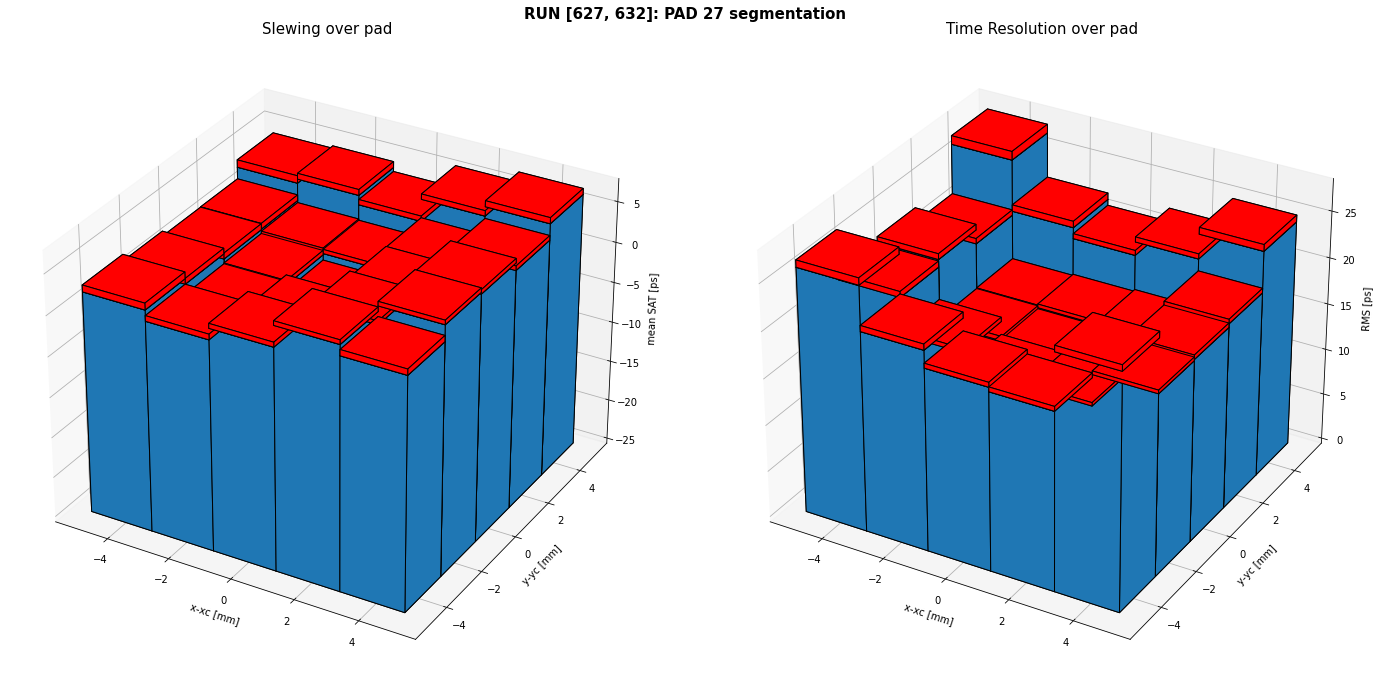

In [23]:
fig = plt.figure(figsize=(20,10))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.subplots_adjust(hspace=0.2)
fig.suptitle(f'RUN {run}: PAD {pad_name[index]} segmentation', fontsize=15, fontweight='bold')

width = depth =step

ax1.bar3d(pad_seed[:,0], pad_seed[:,1], -25, width, depth ,30+pad_seed[:,2], shade=False, 
          edgecolor = 'black')
ax1.bar3d(pad_seed[:,0], pad_seed[:,1], 5+pad_seed[:,2], width, depth ,pad_seed[:,3], 
          shade=False,color ='red', edgecolor = 'black')
ax1.set_xlabel('x-xc [mm]')
ax1.set_ylabel('y-yc [mm]')
ax1.set_zlabel('mean SAT [ps]')
ax1.set_title('Slewing over pad', fontsize=15)


ax2.bar3d(pad_seed[:,0], pad_seed[:,1], 0, width, depth,pad_seed[:,4], shade=False, 
          edgecolor = 'black')
ax2.bar3d(pad_seed[:,0], pad_seed[:,1],pad_seed[:,4], width, depth, pad_seed[:,5], shade=False,
         color ='red',edgecolor = 'black')
ax2.set_xlabel('x-xc [mm]')
ax2.set_ylabel('y-yc [mm]')
ax2.set_zlabel('RMS [ps]')
ax2.set_title('Time Resolution over pad', fontsize=15)

plt.show()

In [24]:
#theta: r,sat,sat_error, rms, rms_error
projection_seed = []
for theta in [0,np.pi/4,np.pi/2, 3*np.pi/4]:
    arr = np.empty((0,5))
    for r in range(-5,6,1):
        x0 = xc +r*np.cos(theta)
        y0 = yc +r*np.sin(theta)
        
        x = data.iloc[:,-4].values
        y = data.iloc[:,-3].values
        x,y = transfo(x,y,cross_beam[0],cross_beam[1],theta_local) #rotate only tracks
        
        seed =np.logical_and( mm_basic_cut,np.sqrt((x-x0)**2 + (y-y0)**2)<0.5)
        
        cable =cable_delay[index]-10
        q_scale = p2[index]*data[mm_qall][seed]+p3[index]
        cor = double_expo(q_scale, *slew_par)
        sat = (data[mm_t][seed] - data.mcp_t[seed])*1000 -cable - cor #ps
        sat = sat[np.abs(sat)<=1000]
        
        sat_pad_seed = ROOT.TH1F("", "",
                                 50,sat.mean()-5*sat.std(),sat.mean()+5*sat.std())
        
        sat_pad_seed.FillN(len(sat), sat.values, np.ones(len(sat)) )
        result = sat_pad_seed.Fit("gaus","SQ")
        arr = np.append(arr,
                             np.array([[r, result.Parameter(1),result.ParError(1), 
                                        result.Parameter(2),result.ParError(2)]]),
                            axis = 0)
        
    projection_seed.append(arr)
        


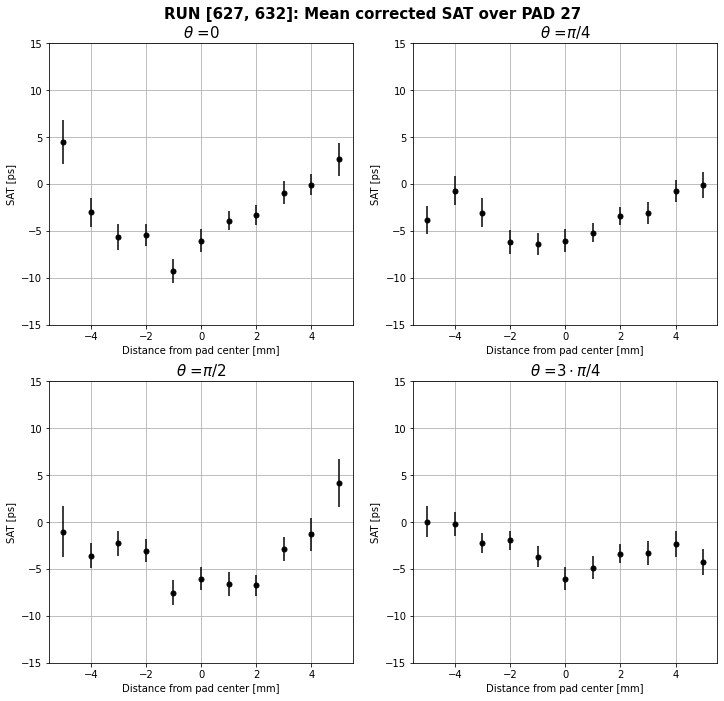

In [25]:
fig, axes = plt.subplots(figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f'RUN {run}: Mean corrected SAT over PAD {pad_name[index]} ',
             fontsize=15, fontweight='bold')

i=0
for theta in ['0','$\pi/4$','$\pi/2$', '$3\cdot\pi/4$']:
    plt.subplot(2, 2, i + 1)
    
    x = projection_seed[i][:,0]
    y = projection_seed[i][:,1]
    y_er = projection_seed[i][:,2]
    
    plt.errorbar(x,y, yerr =y_er ,fmt='o', markersize=5.,color = 'black' )
    plt.title(r'$\theta$ =' f'{theta}',fontsize=15)
    plt.xlabel('Distance from pad center [mm]')
    plt.ylabel('SAT [ps]')
    plt.ylim(-15,15)
    plt.grid()

    i = i+1


plt.show()

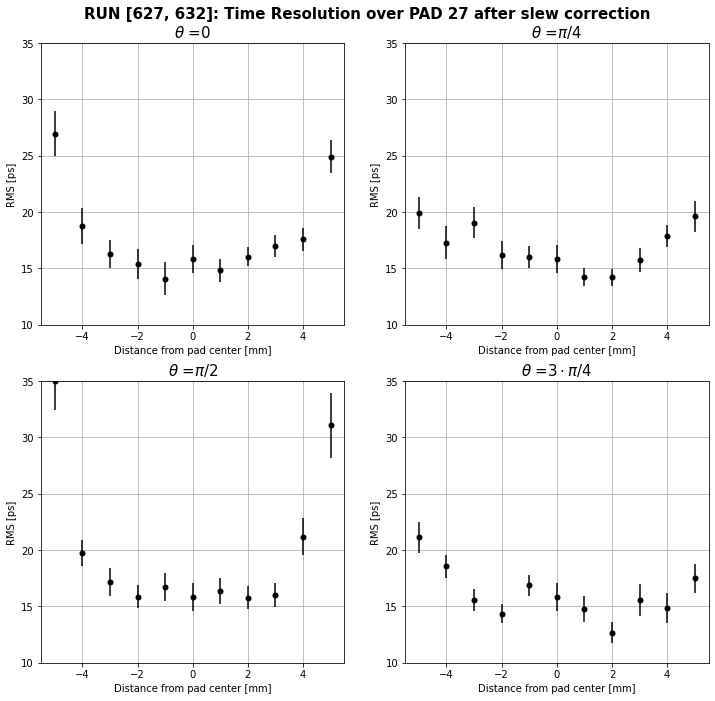

In [26]:
fig, axes = plt.subplots(figsize=(10,10))
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
fig.suptitle(f'RUN {run}: Time Resolution over PAD {pad_name[index]} after slew correction',
             fontsize=15, fontweight='bold')

i=0
for theta in ['0','$\pi/4$','$\pi/2$', '$3\cdot\pi/4$']:
    plt.subplot(2, 2, i + 1)
    
    x = projection_seed[i][:,0]
    y = projection_seed[i][:,3]
    y_er = projection_seed[i][:,4]
    
    plt.errorbar(x,y, yerr =y_er ,fmt='o', markersize=5.,color ='black' )
    plt.title(r'$\theta$ =' f'{theta}',fontsize=15)
    plt.xlabel('Distance from pad center [mm]')
    plt.ylabel('RMS [ps]')
    plt.ylim(10,35)
    plt.grid()
    
    i = i+1


plt.show()